<a href="https://colab.research.google.com/github/jmcaussade/analitica-textual-con-machine-learning-tarea3/blob/main/Tarea3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Laboratorio 3 - Laboratorio de Clasificación utilizando Transformers
#Curso Analítica Textual con Machine Learning

Profesora: Carla Vairetti



En este laboratorio, realizaremos una clasificación binaria en un conjunto de datos utilizando un modelo BERT preentrenado de la biblioteca Transformers de Hugging Face. Vamos a seguir los pasos para cargar un modelo, tokenizar los datos, preparar el conjunto de datos y entrenar el modelo.

## ¿Qué son los Transformers?
Los Transformers son un tipo de arquitectura de modelos que ha revolucionado el campo del Procesamiento del Lenguaje Natural (NLP). Desarrollados inicialmente para tareas como la traducción, estos modelos sobresalen en la comprensión del contexto en datos textuales.

La biblioteca `transformers` de Hugging Face proporciona acceso fácil a modelos preentrenados, incluyendo BERT, GPT, T5, y muchos otros. Estos modelos pueden utilizarse para diversas tareas como clasificación de texto, traducción, resumen, y más.

### Encontrar Modelos en Hugging Face
Puedes explorar modelos en el [Hugging Face Model Hub](https://huggingface.co/models). Los modelos están categorizados por tarea y lenguaje. Puedes buscar modelos según tus necesidades y usarlos directamente en tu código.



## Paso 1: Montar Google Drive
Comenzamos montando Google Drive para acceder al conjunto de datos y guardar cualquier salida.


In [48]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



## Paso 2: Importar las Bibliotecas Necesarias
A continuación, importamos las bibliotecas necesarias. Estas incluyen:
- `transformers` para cargar y trabajar con modelos transformadores,
- `pandas` y `numpy` para el manejo de datos,
- `torch` para trabajar con PyTorch (la base de nuestros modelos),
- `sklearn` para evaluar el modelo,
- `matplotlib` y `seaborn` para realizar gráficos.


In [49]:
import io
import os
import copy
import torch
import json
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import (AutoConfig,
                          AutoModelForSequenceClassification,
                          AutoTokenizer, AdamW,
                          get_linear_schedule_with_warmup,
                          set_seed,
                          )
from sklearn.utils.class_weight import compute_class_weight
import warnings

tqdm.pandas()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

warnings.filterwarnings("ignore", category=UserWarning)




## Paso 3: Configuración del Modelo
Utilizaremos un modelo BERT preentrenado específico para español (`dccuchile/bert-base-spanish-wwm-cased`) del Hugging Face Model Hub. Este modelo está preentrenado en un gran corpus de texto en español y es adecuado para nuestra tarea de clasificación.


In [50]:
model_path = 'dccuchile/bert-base-spanish-wwm-cased'
model_alias = 'BERT'


## Paso 4: Definir Hiperparámetros
Definimos algunos hiperparámetros esenciales:
- `max_length`: La longitud máxima de la entrada tokenizada.
- `epochs`: Número de épocas de entrenamiento.
- `batch_size`: El tamaño del lote para el entrenamiento.
- `n_labels`: Número de etiquetas en la tarea de clasificación.
- `learning_rate`: La tasa de aprendizaje para el optimizador.


In [51]:
max_length = 512
epochs = 3
batch_size = 8
n_labels = 3
warmup_epochs = 0.2 * epochs
learning_rate = 1e-5


## Paso 5: Cargar el Tokenizador y el Modelo
Cargamos el tokenizador y el modelo utilizando la biblioteca `transformers`. El tokenizador convertirá el texto en tokens que el modelo puede procesar.


In [52]:
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_path)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [53]:
model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_path, num_labels=n_labels)

model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_path,
                                                           config=model_config)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e


## Paso 6: Cargar y Preprocesar los Datos
Cargamos el conjunto de datos desde un archivo Excel. El conjunto de datos contiene reseñas de restaurantes con una calificación correspondiente. Luego, simplificamos las calificaciones en tres categorías: `Negativo`, `Neutral` y `Positivo`.


In [54]:
df = pd.read_pickle('/content/drive/My Drive/2024-02/Analitica_textual_con_ML/Tarea2ML/df_procesadoOficial.pkl')
df

,id,rank,abstract,review,processed_review,filtered_words,token_count,joined_text
0,1,2,Un hotel digno de mención!,Como bien les comenté a los propietarios a la ...,"[bien, comente, propietarios, hora, abandonar,...","[hora, momento, vez, granada, situacion, centr...",76,hora momento vez granada situacion centro gran...
1,2,2,"Recomendable 100%, sin lujos pero todo perfecto.","Estuvimos dos días con mi familia, reservando ...","[dias, familia, reservando, habitaciones, desa...","[dias, familia, incluido, incluso, parking, es...",84,dias familia incluido incluso parking estancia...
2,3,1,Decepción,Habíamos escogido este hotel por las buenas op...,"[escogido, hotel, buenas, opiniones, verdad, h...","[buenas, verdad, centro, hacia, ruido, poder, ...",53,buenas verdad centro hacia ruido poder suelo p...
3,4,2,"Por segunda vez, inmejorable",Hemos vuelto por segunda vez a este estupendo ...,"[vuelto, segunda, vez, estupendo, hotel, grana...","[vez, estupendo, granada, relacion, calidad, p...",47,vez estupendo granada relacion calidad precio ...
4,5,2,No tan sorpresa,"He estado dos días en Granada por trabajo, soy...","[dias, granada, trabajo, autonomo, busco, ante...","[dias, granada, elegir, pues, situacion, cerca...",91,dias granada elegir pues situacion cerca grana...
...,...,...,...,...,...,...,...,...
1811,1812,2,remanso de paz en el corazón de Córdoba,Hemos empezado el año con una estancia de tres...,"[empezado, ano, estancia, tres, noches, hotel,...","[estancia, tres, noches, lugar, tranquilo, tra...",116,estancia tres noches lugar tranquilo trato com...
1812,1813,2,"Oasis de paz, tranquilidad y belleza!",Al atravesar el umbral de la puerta que conduc...,"[atravesar, umbral, puerta, conduce, zaguan, h...","[puerta, olor, natural, patio, patio, calidad,...",242,puerta olor natural patio patio calidad vista ...
1813,1814,2,Un lugar para recordar,En este hotel todo son sensaciones y experienc...,"[hotel, sensaciones, experiencias, positivas, ...","[ubicado, antigua, calle, ahora, junto, zona, ...",109,ubicado antigua calle ahora junto zona gran ha...
1814,1815,2,Extraordinario,Hemos pasado un par de noches en este exquisit...,"[pasado, par, noches, exquisito, hotel, regent...","[pasado, par, noches, trato, primera, planta, ...",31,pasado par noches trato primera planta cama gu...


In [55]:
df = df[['abstract', 'review', 'rank']]
df

,abstract,review,rank
0,Un hotel digno de mención!,Como bien les comenté a los propietarios a la ...,2
1,"Recomendable 100%, sin lujos pero todo perfecto.","Estuvimos dos días con mi familia, reservando ...",2
2,Decepción,Habíamos escogido este hotel por las buenas op...,1
3,"Por segunda vez, inmejorable",Hemos vuelto por segunda vez a este estupendo ...,2
4,No tan sorpresa,"He estado dos días en Granada por trabajo, soy...",2
...,...,...,...
1811,remanso de paz en el corazón de Córdoba,Hemos empezado el año con una estancia de tres...,2
1812,"Oasis de paz, tranquilidad y belleza!",Al atravesar el umbral de la puerta que conduc...,2
1813,Un lugar para recordar,En este hotel todo son sensaciones y experienc...,2
1814,Extraordinario,Hemos pasado un par de noches en este exquisit...,2



## Paso 7: Preparar el Conjunto de Datos
Dividimos los datos en conjuntos de entrenamiento y prueba. También creamos un `Dataset` personalizado de PyTorch para manejar las entradas tokenizadas.


rank
2    1020
0     511
1     285
Name: count, dtype: int64


<Axes: xlabel='rank'>

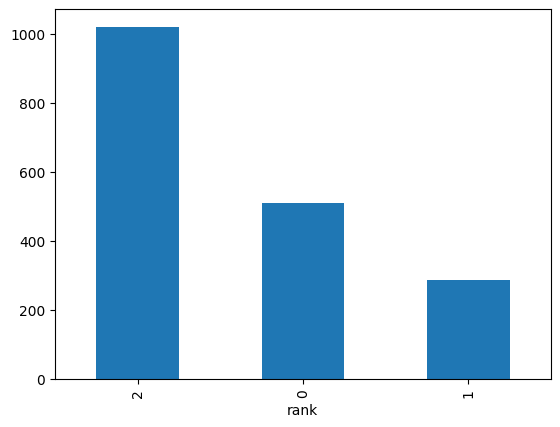

In [56]:
print(df['rank'].value_counts())
df['rank'].value_counts().plot(kind='bar')

Para el entrenamiento de transformers, los tokenizers retornan 3 elemento:

1. **`input_ids`**:
   - Este tensor contiene los IDs de los tokens que representan el texto de entrada. Cada número corresponde a un token específico en el vocabulario del modelo.
   - Los tokens pueden incluir palabras, partes de palabras, o incluso caracteres individuales, dependiendo de cómo se haya tokenizado el texto de entrada.
   - En este ejemplo, el tensor tiene una longitud fija, y los valores `1` al final indican que se ha utilizado un padding para completar la secuencia hasta el tamaño máximo permitido por el modelo.

2. **`token_type_ids`**:
   - Este tensor se utiliza principalmente en modelos como BERT para diferenciar entre dos secuencias diferentes cuando se realizan tareas como preguntas y respuestas o clasificación de pares de oraciones.
   - En este caso, todos los valores son `0`, lo que sugiere que se trata de una sola secuencia de entrada. Si hubiera dos secuencias (como en una tarea de pares de oraciones), se usarían `0` y `1` para distinguirlas.

3. **`attention_mask`**:
   - Este tensor indica al modelo qué tokens debe prestar atención y cuáles debe ignorar (por ejemplo, debido al padding).
   - Los valores `1` indican que el modelo debe prestar atención a esos tokens, mientras que los `0` indican que el modelo debe ignorarlos.
   - En este caso, los primeros valores son `1`, correspondientes a los tokens reales del texto, y los valores al final son `0`, correspondientes a los tokens de padding.

In [57]:
tok_example = tokenizer(df['review'].iloc[0], return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
tok_example

{'input_ids': tensor([[    4,  2144,  1311,  2027,  5609, 30958,  1013,  1065, 12220,  1013,
          1030,  2709,  1008,  9981,  1040,  5225,  1017,  1084, 22340, 30958,
          1049,  1989,  1036, 17274,  1108,  1042,  1861,  1480,  1040,  9762,
         21296, 30933,  1008, 13410,  1009,  1508,  2504,  2440,  1072,  3040,
          1008, 13410,  1084,  1058,  1030,  1627,  1017,  1355,  1110,  3070,
         17182,  1538,  6719,  1147, 19189,  1093,  1008,  1377,  1008,  3165,
          1051,  6054,  1013,  1030,  1403,  5159,  2883,  1135,  1009,  1264,
          2858,  1036,  1030,  6278,  1008,  3661,  1013,  8909, 24408,  1042,
          1456, 10082,  1013,  1030,  1403,  5159,  2883,  1009,  1278,  1030,
          2785,  1062,  1499,  2604, 18173,  1042,  1365,  1062,  2858,  1036,
          1108,  2785,  4488,  1042, 13248,  1009,  1412,  1080,   981,  9794,
          1072,  3040,  1008, 13410,  1038,  1445, 17274,  1022,  1036,  1040,
          5225,  2351,  1114,  1038,  

In [58]:
tokenizer.decode(tok_example['input_ids'][0])

'[CLS] Como bien les comenté a los propietarios a la hora de abandonar el hotel, no dudaré un momento en recomendar una y otra vez el Hotel Albero de Granada. Su situación respecto del centro de Granada no es la mejor, pero para nuestros propósitos era perfecto ( escapada de fin de semana con visita a la Alhambra ). Se encuentra en la carretera de paso a Sierra Nevada y muy cercano a la Alhambra. Por la zona se puede encontrar aparcamiento y este se encuentra en una zona segura y tranquila. Los parkings del centro de Granada que nos recomendaron en el hotel fueron lo que nos dijeron ( nada caros ) y pudimos movernos por el centro perfectamente desde allí. Las habitaciones muy limpias y las camas confortables. El desayuno fue espectacular. Ya teníamos buenas referencias de este maravilloso hotel de una estrella ( que para mí que viajo constantemente son más ) pero ha superado con creces nuestras expectativas. Si vuelvo a Granada no dudaré en hospedarme en el mismo hotel. Muchas gracias 

Ahora podemos utilizar dos secuencias de texto individuales pero tokenizarlas juntas agregando el token serarador ([SEP] en el caso de BETO).

In [59]:
tok_doble_example = tokenizer(df['abstract'].iloc[0], df['review'].iloc[0], return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
tok_doble_example

{'input_ids': tensor([[    4,  1246,  5225, 16901,  1008, 15450,  1127,     5,  2144,  1311,
          2027,  5609, 30958,  1013,  1065, 12220,  1013,  1030,  2709,  1008,
          9981,  1040,  5225,  1017,  1084, 22340, 30958,  1049,  1989,  1036,
         17274,  1108,  1042,  1861,  1480,  1040,  9762, 21296, 30933,  1008,
         13410,  1009,  1508,  2504,  2440,  1072,  3040,  1008, 13410,  1084,
          1058,  1030,  1627,  1017,  1355,  1110,  3070, 17182,  1538,  6719,
          1147, 19189,  1093,  1008,  1377,  1008,  3165,  1051,  6054,  1013,
          1030,  1403,  5159,  2883,  1135,  1009,  1264,  2858,  1036,  1030,
          6278,  1008,  3661,  1013,  8909, 24408,  1042,  1456, 10082,  1013,
          1030,  1403,  5159,  2883,  1009,  1278,  1030,  2785,  1062,  1499,
          2604, 18173,  1042,  1365,  1062,  2858,  1036,  1108,  2785,  4488,
          1042, 13248,  1009,  1412,  1080,   981,  9794,  1072,  3040,  1008,
         13410,  1038,  1445, 17274,  

In [60]:
tokenizer.decode(tok_doble_example['input_ids'][0])

'[CLS] Un hotel digno de mención! [SEP] Como bien les comenté a los propietarios a la hora de abandonar el hotel, no dudaré un momento en recomendar una y otra vez el Hotel Albero de Granada. Su situación respecto del centro de Granada no es la mejor, pero para nuestros propósitos era perfecto ( escapada de fin de semana con visita a la Alhambra ). Se encuentra en la carretera de paso a Sierra Nevada y muy cercano a la Alhambra. Por la zona se puede encontrar aparcamiento y este se encuentra en una zona segura y tranquila. Los parkings del centro de Granada que nos recomendaron en el hotel fueron lo que nos dijeron ( nada caros ) y pudimos movernos por el centro perfectamente desde allí. Las habitaciones muy limpias y las camas confortables. El desayuno fue espectacular. Ya teníamos buenas referencias de este maravilloso hotel de una estrella ( que para mí que viajo constantemente son más ) pero ha superado con creces nuestras expectativas. Si vuelvo a Granada no dudaré en hospedarme e

In [61]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=1)

La clase `DatasetFromDataFrame` es una clase personalizada que extiende la funcionalidad de `Dataset` de PyTorch para manejar datos almacenados en un DataFrame de Pandas. Esta clase facilita la preparación de datos para un modelo de aprendizaje profundo.

- **`__init__`**: Guarda el DataFrame que contiene los datos.
- **`__len__`**: Devuelve el número total de ejemplos en el dataset, es decir, el número de filas en el DataFrame.
- **`__getitem__`**: Dado un índice, recupera un ejemplo del dataset. Específicamente, devuelve la etiqueta (rating) y dos textos (el título y el comentario) correspondientes a ese índice.

In [62]:
class DatasetFromDataFrame(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        label = int(self.data.iloc[index]['rank'])
        text_1 = str(self.data.iloc[index]['abstract'])
        text_2 = str(self.data.iloc[index]['review']) ###
        return label, text_1, text_2

Ahora inicializamos los datos para el entrenamiento y la validación de un modelo de aprendizaje profundo usando PyTorch:

- **`train_dataset = DatasetFromDataFrame(train_df)`**:
  - Crea un objeto `DatasetFromDataFrame` usando el DataFrame de entrenamiento `train_df`. Este objeto `train_dataset` organizará y permitirá acceder a los datos de entrenamiento en la forma que PyTorch necesita.

- **`train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)`**:
  - Crea un `DataLoader` a partir del dataset de entrenamiento (`train_dataset`). El `DataLoader` es responsable de dividir los datos en lotes (`batch_size`) y de barajarlos aleatoriamente (`shuffle=True`) en cada época de entrenamiento. Esto ayuda a mejorar la eficacia del entrenamiento al mezclar los datos.

- **`valid_dataset =  DatasetFromDataFrame(val_df)`**:
  - Crea un objeto `DatasetFromDataFrame` usando el DataFrame de validación `val_df`. Esto organiza los datos de validación de manera similar a los datos de entrenamiento.

- **`test_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)`**:
  - Crea un `DataLoader` para el dataset de validación (`valid_dataset`). Aquí, los datos no se barajan (`shuffle=False`), ya que el orden no importa tanto para la validación, y queremos mantener consistencia para evaluar el rendimiento del modelo.

In [63]:
train_dataset = DatasetFromDataFrame(train_df)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset =  DatasetFromDataFrame(val_df)
test_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)



## Paso 8: Entrenamiento del Modelo



Un **optimizador** es una herramienta que ajusta los parámetros del modelo para mejorar su rendimiento, buscando minimizar los errores que comete durante el entrenamiento.

Este código crea un **optimizador AdamW**, que es una versión mejorada del optimizador Adam. Su función es ajustar los parámetros del modelo (`model.parameters()`) durante el entrenamiento para reducir los errores. La **tasa de aprendizaje** (`lr = learning_rate`) determina qué tan grandes son los ajustes en cada paso. AdamW es especialmente útil porque maneja bien grandes conjuntos de datos y evita que los parámetros se desajusten demasiado.

In [64]:
optimizer = torch.optim.AdamW(model.parameters(),
                              lr = learning_rate)

Este código sigue un flujo típico de entrenamiento y evaluación, donde el modelo aprende de los datos de entrenamiento y luego se evalúa en datos de validación para asegurarse de que está mejorando, eligiendo la mejor epoca segun la metrica Accuracy en el la evaluación:

1. **Variables Iniciales**:
   - `best_epoch` y `best_accuracy` se inicializan en 0 para rastrear la mejor época y la mejor precisión alcanzada durante el entrenamiento.

2. **Training Loop (`for epoch in tqdm(range(epochs))`)**:
   - **Entrenamiento**:
     - **Preparación**: Se inician listas para las etiquetas verdaderas y predichas (`epoch_true_labels`, `epoch_predicted_labels`) y un contador de pérdida (`total_loss`).
     - **Bucle sobre los datos de entrenamiento**: Por cada lote en `train_dataloader`, se obtienen las etiquetas y los textos, que se tokenizan y envían al modelo.
     - **Actualización del Modelo**: Se calcula la pérdida, se realiza la retropropagación (`loss.backward()`), y se actualizan los parámetros del modelo con el optimizador (`optimizer.step()`).
     - **Monitoreo**: Se acumulan las pérdidas y se calculan las etiquetas predichas, actualizando el progreso en la barra de tareas.

   - **Evaluación**:
     - Similar al entrenamiento, pero sin actualizar los parámetros del modelo (`model.eval()` desactiva el modo de entrenamiento). Se calculan las pérdidas y las etiquetas predichas para los datos de validación.
     - **Comparación de Precisión**: Después de evaluar, se calcula la precisión. Si esta supera la mejor precisión registrada (`best_accuracy`), se actualizan `best_epoch` y `best_accuracy`.
     - **Matriz de Confusión**: Se genera y muestra una matriz de confusión para visualizar el rendimiento del modelo en clasificar las etiquetas.



### 8.1 Solo Review

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       102
           1       0.60      0.22      0.32        55
           2       0.86      0.97      0.91       207

    accuracy                           0.85       364
   macro avg       0.78      0.71      0.71       364
weighted avg       0.82      0.85      0.82       364

*** Best Epoch: 1, Best Accuracy: 0.8489010989010989 ***


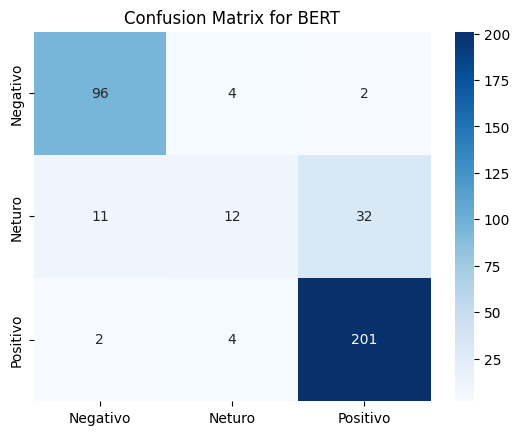

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.92      0.84      0.88       102
           1       0.46      0.40      0.43        55
           2       0.88      0.95      0.91       207

    accuracy                           0.84       364
   macro avg       0.75      0.73      0.74       364
weighted avg       0.83      0.84      0.83       364



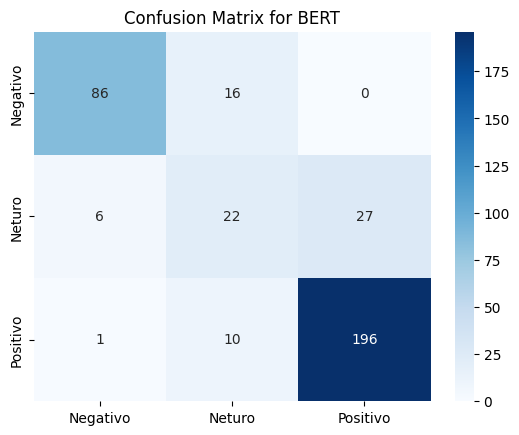

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.95      0.81      0.88       102
           1       0.45      0.85      0.59        55
           2       0.98      0.81      0.89       207

    accuracy                           0.82       364
   macro avg       0.79      0.83      0.78       364
weighted avg       0.89      0.82      0.84       364



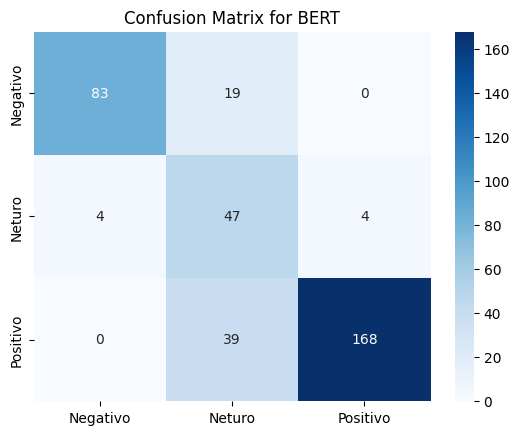

,class,precision,recall,f1-score,model,lema state
0,0,0.880734,0.941176,0.909953,BETO solo Comentario,N.A.
1,1,0.600000,0.218182,0.320000,BETO solo Comentario,N.A.
2,2,0.855319,0.971014,0.909502,BETO solo Comentario,N.A.
3,accuracy,0.848901,0.848901,0.848901,BETO solo Comentario,N.A.
4,macro avg,0.778684,0.710124,0.713152,BETO solo Comentario,N.A.
5,weighted avg,0.823862,0.848901,0.820555,BETO solo Comentario,N.A.


In [65]:
best_epoch = 0
best_accuracy = 0

for epoch in tqdm(range(epochs)):

    # TRAINING
    epoch_true_labels = []
    epoch_predicted_labels = []
    total_loss = 0

    t_bar = tqdm(train_dataloader)
    model.train()

    for step_counter, (labels, text_1, text_2) in enumerate(t_bar):
        labels = labels.to(device)
        inputs = tokenizer(text_2, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
        # inputs = tokenizer(text_1, text_2, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
        inputs['labels'] = labels
        inputs = {k:v.type(torch.long).to(device) for k,v in inputs.items()}

        model.zero_grad()
        optimizer.zero_grad()

        outputs = model(**inputs)

        loss = outputs.loss
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

        predicted_labels = outputs.logits.argmax(dim=1).cpu().tolist()

        epoch_true_labels.extend(labels.cpu().tolist())
        epoch_predicted_labels.extend(predicted_labels)


        epoch_report = classification_report(epoch_true_labels, epoch_predicted_labels, output_dict=True)
        t_bar.set_description(f'Training... EPOCH {epoch+1} Step Loss {total_loss/(step_counter+1):4f}, Epoch Accuracy {epoch_report["accuracy"]:4f}')
        t_bar.refresh()


    # EVALUATION
    epoch_true_labels = []
    epoch_predicted_labels = []
    total_loss = 0

    v_bar = tqdm(test_dataloader)
    model.eval()

    for step_counter, (labels, text_1, text_2) in enumerate(v_bar):
        labels = labels.to(device)
        # inputs = tokenizer(text_1, text_2, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
        inputs = tokenizer(text_2, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
        inputs['labels'] = labels
        inputs = {k:v.type(torch.long).to(device) for k,v in inputs.items()}

        outputs = model(**inputs)

        loss = outputs.loss

        total_loss += loss.item()

        predicted_labels = outputs.logits.argmax(dim=1).cpu().tolist()

        epoch_true_labels.extend(labels.cpu().tolist())
        epoch_predicted_labels.extend(predicted_labels)


        epoch_report = classification_report(epoch_true_labels, epoch_predicted_labels, output_dict=True)
        v_bar.set_description(f'Training... EPOCH {epoch+1} Avg Loss {total_loss/(step_counter+1):4f}, Avg Accuracy {epoch_report["accuracy"]:4f}')
        v_bar.refresh()

    evaluations_report = classification_report(epoch_true_labels, epoch_predicted_labels, output_dict=True)
    print(classification_report(epoch_true_labels, epoch_predicted_labels))
    epoch_accuracy = evaluations_report['accuracy']

    if epoch_accuracy > best_accuracy:
        best_epoch = epoch + 1
        best_accuracy = epoch_accuracy
        best_report = evaluations_report
        print(f'*** Best Epoch: {best_epoch}, Best Accuracy: {best_accuracy} ***')

    conf_matrix = confusion_matrix(epoch_true_labels, epoch_predicted_labels)

    fig, ax = plt.subplots()
    plt.title(f'Confusion Matrix for {model_alias}')
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels={'Negativo': 0,
                            'Neturo': 1,
                            'Positivo': 2},
                yticklabels={'Negativo': 0,
                            'Neturo': 1,
                            'Positivo': 2})
    plt.show()


beto_results_df_review = pd.DataFrame(best_report).T
beto_results_df_review['model'] = 'BETO solo Comentario'
beto_results_df_review['lema state'] = 'N.A.'
beto_results_df_review = beto_results_df_review.drop(columns = ['support'])
beto_results_df_review = beto_results_df_review.reset_index()
beto_results_df_review.rename(columns={'index': 'class'}, inplace=True)

beto_results_df_review

### 8.2 Entrenamiento Titulo y Comentario

In [66]:
model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_path, num_labels=n_labels)

model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_path,
                                                           config=model_config)

optimizer = torch.optim.AdamW(model.parameters(),
                              lr = learning_rate)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.94      0.85      0.89       102
           1       0.58      0.51      0.54        55
           2       0.90      0.97      0.93       207

    accuracy                           0.87       364
   macro avg       0.81      0.78      0.79       364
weighted avg       0.86      0.87      0.86       364

*** Best Epoch: 1, Best Accuracy: 0.8653846153846154 ***


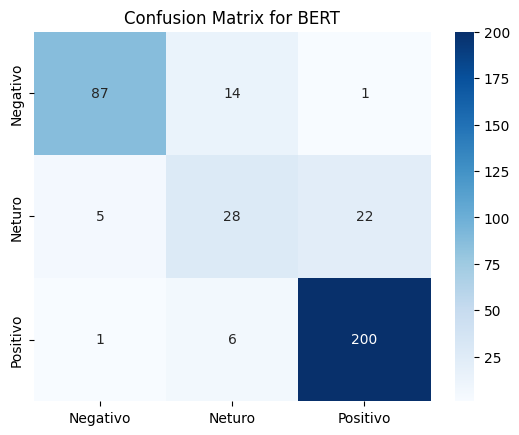

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       102
           1       0.57      0.58      0.58        55
           2       0.92      0.93      0.93       207

    accuracy                           0.87       364
   macro avg       0.80      0.80      0.80       364
weighted avg       0.87      0.87      0.87       364



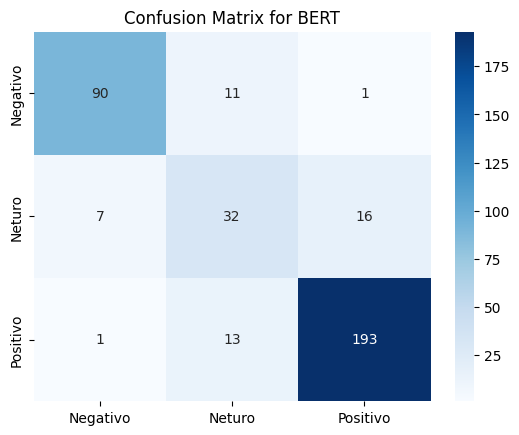

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.84      0.93      0.88       102
           1       0.57      0.45      0.51        55
           2       0.92      0.92      0.92       207

    accuracy                           0.85       364
   macro avg       0.78      0.77      0.77       364
weighted avg       0.85      0.85      0.85       364



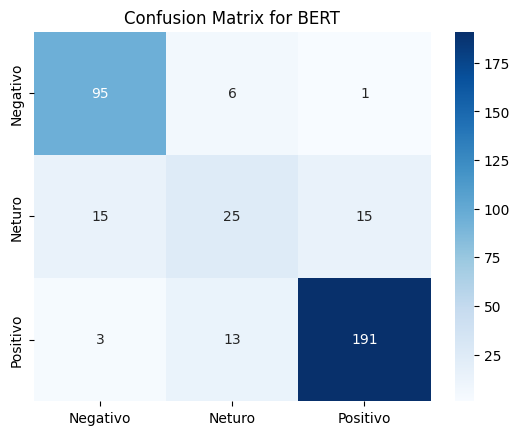

,class,precision,recall,f1-score,model,lema state
0,0,0.935484,0.852941,0.892308,BETO Titulo y Comentario,N.A.
1,1,0.583333,0.509091,0.543689,BETO Titulo y Comentario,N.A.
2,2,0.896861,0.966184,0.930233,BETO Titulo y Comentario,N.A.
3,accuracy,0.865385,0.865385,0.865385,BETO Titulo y Comentario,N.A.
4,macro avg,0.805226,0.776072,0.788743,BETO Titulo y Comentario,N.A.
5,weighted avg,0.860310,0.865385,0.861199,BETO Titulo y Comentario,N.A.


In [67]:
best_epoch = 0
best_accuracy = 0

for epoch in tqdm(range(epochs)):

    # TRAINING
    epoch_true_labels = []
    epoch_predicted_labels = []
    total_loss = 0

    t_bar = tqdm(train_dataloader)
    model.train()

    for step_counter, (labels, text_1, text_2) in enumerate(t_bar):
        labels = labels.to(device)
        inputs = tokenizer(text_1, text_2, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
        inputs['labels'] = labels
        inputs = {k:v.type(torch.long).to(device) for k,v in inputs.items()}

        model.zero_grad()
        optimizer.zero_grad()

        outputs = model(**inputs)

        loss = outputs.loss
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

        predicted_labels = outputs.logits.argmax(dim=1).cpu().tolist()

        epoch_true_labels.extend(labels.cpu().tolist())
        epoch_predicted_labels.extend(predicted_labels)


        epoch_report = classification_report(epoch_true_labels, epoch_predicted_labels, output_dict=True)
        t_bar.set_description(f'Training... EPOCH {epoch+1} Step Loss {total_loss/(step_counter+1):4f}, Epoch Accuracy {epoch_report["accuracy"]:4f}')
        t_bar.refresh()


    # EVALUATION
    epoch_true_labels = []
    epoch_predicted_labels = []
    total_loss = 0

    v_bar = tqdm(test_dataloader)
    model.eval()

    for step_counter, (labels, text_1, text_2) in enumerate(v_bar):
        labels = labels.to(device)
        inputs = tokenizer(text_1, text_2, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
        inputs['labels'] = labels
        inputs = {k:v.type(torch.long).to(device) for k,v in inputs.items()}

        outputs = model(**inputs)

        loss = outputs.loss

        total_loss += loss.item()

        predicted_labels = outputs.logits.argmax(dim=1).cpu().tolist()

        epoch_true_labels.extend(labels.cpu().tolist())
        epoch_predicted_labels.extend(predicted_labels)


        epoch_report = classification_report(epoch_true_labels, epoch_predicted_labels, output_dict=True)
        v_bar.set_description(f'Training... EPOCH {epoch+1} Avg Loss {total_loss/(step_counter+1):4f}, Avg Accuracy {epoch_report["accuracy"]:4f}')
        v_bar.refresh()

    evaluations_report = classification_report(epoch_true_labels, epoch_predicted_labels, output_dict=True)
    print(classification_report(epoch_true_labels, epoch_predicted_labels))
    epoch_accuracy = evaluations_report['accuracy']

    if epoch_accuracy > best_accuracy:
        best_epoch = epoch + 1
        best_accuracy = epoch_accuracy
        best_report = evaluations_report
        print(f'*** Best Epoch: {best_epoch}, Best Accuracy: {best_accuracy} ***')

    conf_matrix = confusion_matrix(epoch_true_labels, epoch_predicted_labels)

    fig, ax = plt.subplots()
    plt.title(f'Confusion Matrix for {model_alias}')
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels={'Negativo': 0,
                            'Neturo': 1,
                            'Positivo': 2},
                yticklabels={'Negativo': 0,
                            'Neturo': 1,
                            'Positivo': 2})
    plt.show()


beto_results_df_abs_plus_review = pd.DataFrame(best_report).T
beto_results_df_abs_plus_review['model'] = 'BETO Titulo y Comentario'
beto_results_df_abs_plus_review['lema state'] = 'N.A.'
beto_results_df_abs_plus_review = beto_results_df_abs_plus_review.drop(columns = ['support'])
beto_results_df_abs_plus_review = beto_results_df_abs_plus_review.reset_index()
beto_results_df_abs_plus_review.rename(columns={'index': 'class'}, inplace=True)

beto_results_df_abs_plus_review

### 8.3 Entrenamiento solo titulo

In [68]:
model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_path, num_labels=n_labels)

model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_path,
                                                           config=model_config)

optimizer = torch.optim.AdamW(model.parameters(),
                              lr = learning_rate)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.77      0.84      0.81       102
           1       1.00      0.05      0.10        55
           2       0.80      0.96      0.87       207

    accuracy                           0.79       364
   macro avg       0.86      0.62      0.59       364
weighted avg       0.82      0.79      0.74       364

*** Best Epoch: 1, Best Accuracy: 0.7912087912087912 ***


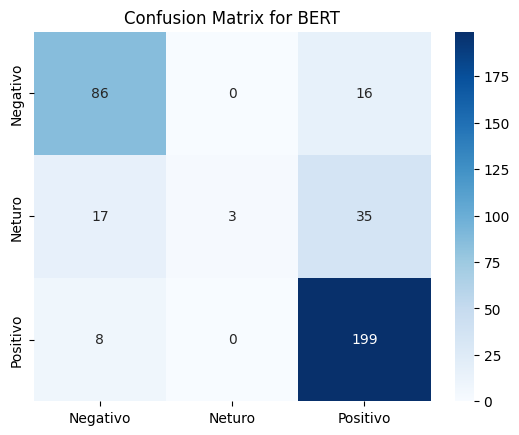

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       102
           1       0.40      0.31      0.35        55
           2       0.85      0.90      0.88       207

    accuracy                           0.79       364
   macro avg       0.68      0.67      0.68       364
weighted avg       0.77      0.79      0.78       364



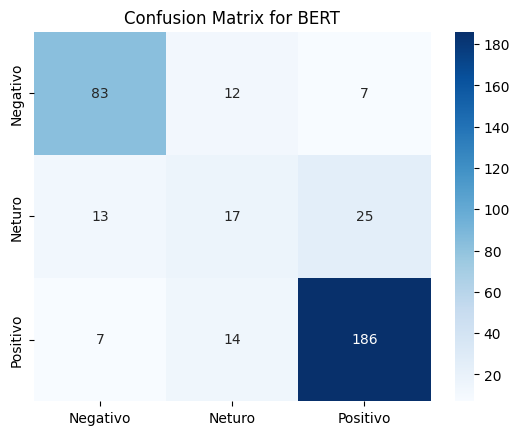

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.72      0.86      0.79       102
           1       0.38      0.33      0.35        55
           2       0.88      0.83      0.85       207

    accuracy                           0.76       364
   macro avg       0.66      0.67      0.66       364
weighted avg       0.76      0.76      0.76       364



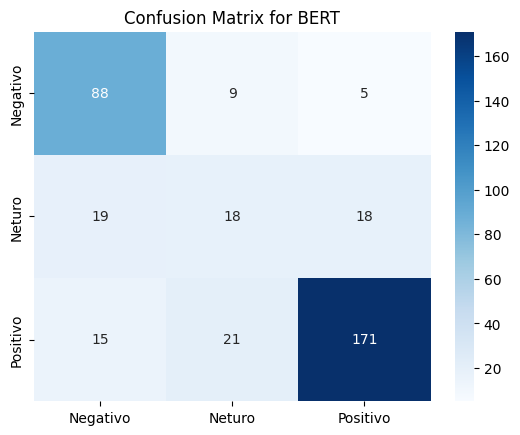

,class,precision,recall,f1-score,model,lema state
0,0,0.774775,0.843137,0.807512,BETO solo Titulo,N.A.
1,1,1.000000,0.054545,0.103448,BETO solo Titulo,N.A.
2,2,0.796000,0.961353,0.870897,BETO solo Titulo,N.A.
3,accuracy,0.791209,0.791209,0.791209,BETO solo Titulo,N.A.
4,macro avg,0.856925,0.619678,0.593952,BETO solo Titulo,N.A.
5,weighted avg,0.820876,0.791209,0.737175,BETO solo Titulo,N.A.


In [69]:
best_epoch = 0
best_accuracy = 0

for epoch in tqdm(range(epochs)):

    # TRAINING
    epoch_true_labels = []
    epoch_predicted_labels = []
    total_loss = 0

    t_bar = tqdm(train_dataloader)
    model.train()

    for step_counter, (labels, text_1, text_2) in enumerate(t_bar):
        labels = labels.to(device)
        inputs = tokenizer(text_1, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
        # inputs = tokenizer(text_1, text_2, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
        inputs['labels'] = labels
        inputs = {k:v.type(torch.long).to(device) for k,v in inputs.items()}

        model.zero_grad()
        optimizer.zero_grad()

        outputs = model(**inputs)

        loss = outputs.loss
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

        predicted_labels = outputs.logits.argmax(dim=1).cpu().tolist()

        epoch_true_labels.extend(labels.cpu().tolist())
        epoch_predicted_labels.extend(predicted_labels)


        epoch_report = classification_report(epoch_true_labels, epoch_predicted_labels, output_dict=True)
        t_bar.set_description(f'Training... EPOCH {epoch+1} Step Loss {total_loss/(step_counter+1):4f}, Epoch Accuracy {epoch_report["accuracy"]:4f}')
        t_bar.refresh()


    # EVALUATION
    epoch_true_labels = []
    epoch_predicted_labels = []
    total_loss = 0

    v_bar = tqdm(test_dataloader)
    model.eval()

    for step_counter, (labels, text_1, text_2) in enumerate(v_bar):
        labels = labels.to(device)
        # inputs = tokenizer(text_1, text_2, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
        inputs = tokenizer(text_1, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
        inputs['labels'] = labels
        inputs = {k:v.type(torch.long).to(device) for k,v in inputs.items()}

        outputs = model(**inputs)

        loss = outputs.loss

        total_loss += loss.item()

        predicted_labels = outputs.logits.argmax(dim=1).cpu().tolist()

        epoch_true_labels.extend(labels.cpu().tolist())
        epoch_predicted_labels.extend(predicted_labels)


        epoch_report = classification_report(epoch_true_labels, epoch_predicted_labels, output_dict=True)
        v_bar.set_description(f'Training... EPOCH {epoch+1} Avg Loss {total_loss/(step_counter+1):4f}, Avg Accuracy {epoch_report["accuracy"]:4f}')
        v_bar.refresh()

    evaluations_report = classification_report(epoch_true_labels, epoch_predicted_labels, output_dict=True)
    print(classification_report(epoch_true_labels, epoch_predicted_labels))
    epoch_accuracy = evaluations_report['accuracy']

    if epoch_accuracy > best_accuracy:
        best_epoch = epoch + 1
        best_accuracy = epoch_accuracy
        best_report = evaluations_report
        print(f'*** Best Epoch: {best_epoch}, Best Accuracy: {best_accuracy} ***')

    conf_matrix = confusion_matrix(epoch_true_labels, epoch_predicted_labels)

    fig, ax = plt.subplots()
    plt.title(f'Confusion Matrix for {model_alias}')
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels={'Negativo': 0,
                            'Neturo': 1,
                            'Positivo': 2},
                yticklabels={'Negativo': 0,
                            'Neturo': 1,
                            'Positivo': 2})
    plt.show()


beto_results_df_abs = pd.DataFrame(best_report).T
beto_results_df_abs['model'] = 'BETO solo Titulo'
beto_results_df_abs['lema state'] = 'N.A.'
beto_results_df_abs = beto_results_df_abs.drop(columns = ['support'])
beto_results_df_abs = beto_results_df_abs.reset_index()
beto_results_df_abs.rename(columns={'index': 'class'}, inplace=True)

beto_results_df_abs

## Paso 9: Manejo resultados

### 9.1 Solo review

In [70]:
df_solo_review = pd.read_pickle('/content/drive/My Drive/2024-02/Analitica_textual_con_ML/Tarea2ML/BaseLab3/df_procesadoExportadoTarea2_SOLOREVIEW.pkl')
df_solo_review

,class,precision,recall,f1-score,model,lema state
0,0,0.363636,0.431373,0.394619,Naive Bayes,Lemma
1,1,0.157895,0.054545,0.081081,Naive Bayes,Lemma
2,2,0.656250,0.710145,0.682135,Naive Bayes,Lemma
3,accuracy,0.532967,0.532967,0.532967,Naive Bayes,Lemma
4,macro avg,0.392594,0.398688,0.385945,Naive Bayes,Lemma
...,...,...,...,...,...,...
67,1,0.153846,0.072727,0.098765,Neural Network,Not Lemma
68,2,0.582090,0.565217,0.573529,Neural Network,Not Lemma
69,accuracy,0.450549,0.450549,0.450549,Neural Network,Not Lemma
70,macro avg,0.349935,0.353171,0.344042,Neural Network,Not Lemma


In [73]:
results_df_solo_review = pd.concat([df_solo_review, beto_results_df_review])
results_df_solo_review.reset_index(inplace=True)
results_d_solo_review = results_df_solo_review.drop(columns = ['index'])
results_df_solo_review

,index,class,precision,recall,f1-score,model,lema state
0,0,0,0.363636,0.431373,0.394619,Naive Bayes,Lemma
1,1,1,0.157895,0.054545,0.081081,Naive Bayes,Lemma
2,2,2,0.656250,0.710145,0.682135,Naive Bayes,Lemma
3,3,accuracy,0.532967,0.532967,0.532967,Naive Bayes,Lemma
4,4,macro avg,0.392594,0.398688,0.385945,Naive Bayes,Lemma
...,...,...,...,...,...,...,...
73,1,1,0.600000,0.218182,0.320000,BETO solo Comentario,N.A.
74,2,2,0.855319,0.971014,0.909502,BETO solo Comentario,N.A.
75,3,accuracy,0.848901,0.848901,0.848901,BETO solo Comentario,N.A.
76,4,macro avg,0.778684,0.710124,0.713152,BETO solo Comentario,N.A.


### 9.2 Solo título y Título + Review

In [71]:
df_abs_and_abs_plus_review = pd.read_pickle('/content/drive/My Drive/2024-02/Analitica_textual_con_ML/Tarea2ML/BaseLab3/df_procesadoExportadoTarea2_SOLOTITULO_PLUS_CONCATENACION.pkl')
df_abs_and_abs_plus_review

,class,precision,recall,f1-score,model,feature_set
0,0,0.750000,0.647059,0.694737,Naive Bayes,abstract
1,1,0.666667,0.072727,0.131148,Naive Bayes,abstract
2,2,0.744444,0.971014,0.842767,Naive Bayes,abstract
3,accuracy,0.744505,0.744505,0.744505,Naive Bayes,abstract
4,macro avg,0.720370,0.563600,0.556217,Naive Bayes,abstract
...,...,...,...,...,...,...
67,1,0.428571,0.381818,0.403846,Neural Network,abstract + comentario_tokenizado_lema
68,2,0.858491,0.879227,0.868735,Neural Network,abstract + comentario_tokenizado_lema
69,accuracy,0.793956,0.793956,0.793956,Neural Network,abstract + comentario_tokenizado_lema
70,macro avg,0.707338,0.701394,0.703869,Neural Network,abstract + comentario_tokenizado_lema


In [74]:
#Separamos en 2 dataframes

df_abstract = df_abs_and_abs_plus_review[df_abs_and_abs_plus_review['feature_set'] == 'abstract']
df_abstract_comentario = df_abs_and_abs_plus_review[df_abs_and_abs_plus_review['feature_set'] == 'abstract + comentario_tokenizado_lema']


#### 9.1.1 Solo titulo

In [75]:
results_df_solo_titulo = pd.concat([df_abstract, beto_results_df_abs])
results_df_solo_titulo.reset_index(inplace=True)
results_d_solo_titulo = results_df_solo_titulo.drop(columns = ['index'])
results_df_solo_titulo

,index,class,precision,recall,f1-score,model,feature_set,lema state
0,0,0,0.750000,0.647059,0.694737,Naive Bayes,abstract,NaN
1,1,1,0.666667,0.072727,0.131148,Naive Bayes,abstract,NaN
2,2,2,0.744444,0.971014,0.842767,Naive Bayes,abstract,NaN
3,3,accuracy,0.744505,0.744505,0.744505,Naive Bayes,abstract,NaN
4,4,macro avg,0.720370,0.563600,0.556217,Naive Bayes,abstract,NaN
5,5,weighted avg,0.734249,0.744505,0.693761,Naive Bayes,abstract,NaN
6,6,0,0.717172,0.696078,0.706468,Logistic Regression,abstract,NaN
7,7,1,0.380952,0.145455,0.210526,Logistic Regression,abstract,NaN
8,8,2,0.782787,0.922705,0.847007,Logistic Regression,abstract,NaN
9,9,accuracy,0.741758,0.741758,0.741758,Logistic Regression,abstract,NaN


#### 9.1.2  Titulo + review

In [77]:
results_df_abstract_comentario = pd.concat([df_abstract_comentario, beto_results_df_abs_plus_review])
results_df_abstract_comentario.reset_index(inplace=True)
results_df_abstract_comentario = results_df_abstract_comentario.drop(columns = ['index'])
results_df_abstract_comentario

,class,precision,recall,f1-score,model,feature_set,lema state
0,0,0.819048,0.843137,0.830918,Naive Bayes,abstract + comentario_tokenizado_lema,NaN
1,1,0.333333,0.018182,0.034483,Naive Bayes,abstract + comentario_tokenizado_lema,NaN
2,2,0.792969,0.980676,0.876890,Naive Bayes,abstract + comentario_tokenizado_lema,NaN
3,accuracy,0.796703,0.796703,0.796703,Naive Bayes,abstract + comentario_tokenizado_lema,NaN
4,macro avg,0.648450,0.613998,0.580763,Naive Bayes,abstract + comentario_tokenizado_lema,NaN
5,weighted avg,0.730826,0.796703,0.736721,Naive Bayes,abstract + comentario_tokenizado_lema,NaN
6,0,0.846154,0.862745,0.854369,Logistic Regression,abstract + comentario_tokenizado_lema,NaN
7,1,0.312500,0.090909,0.140845,Logistic Regression,abstract + comentario_tokenizado_lema,NaN
8,2,0.811475,0.956522,0.878049,Logistic Regression,abstract + comentario_tokenizado_lema,NaN
9,accuracy,0.799451,0.799451,0.799451,Logistic Regression,abstract + comentario_tokenizado_lema,NaN


## Paso 10: Resultados

### 10.1 Solo review

In [84]:
# Sorting the DataFrame by 'f1-score' in descending order
results_df_solo_comentario = results_df_solo_review.sort_values(by='f1-score', ascending=False)

# Display the sorted DataFrame
results_df_solo_comentario

,index,class,precision,recall,f1-score,model,lema state
72,0,0,0.880734,0.941176,0.909953,BETO solo Comentario,N.A.
74,2,2,0.855319,0.971014,0.909502,BETO solo Comentario,N.A.
75,3,accuracy,0.848901,0.848901,0.848901,BETO solo Comentario,N.A.
77,5,weighted avg,0.823862,0.848901,0.820555,BETO solo Comentario,N.A.
20,20,2,0.654762,0.797101,0.718954,Random Forest,Lemma
...,...,...,...,...,...,...,...
49,49,1,0.000000,0.000000,0.000000,SVM,Not Lemma
19,19,1,0.000000,0.000000,0.000000,Random Forest,Lemma
55,55,1,0.000000,0.000000,0.000000,Random Forest,Not Lemma
43,43,1,0.000000,0.000000,0.000000,Logistic Regression,Not Lemma


### 10.2 Titulo + Review

In [81]:
# Sorting the DataFrame by 'f1-score' in descending order
results_df_abstract_comentario_sorted = results_df_abstract_comentario.sort_values(by='f1-score', ascending=False)

# Display the sorted DataFrame
results_df_abstract_comentario_sorted

,class,precision,recall,f1-score,model,feature_set,lema state
38,2,0.896861,0.966184,0.930233,BETO Titulo y Comentario,NaN,N.A.
36,0,0.935484,0.852941,0.892308,BETO Titulo y Comentario,NaN,N.A.
14,2,0.815261,0.980676,0.890351,SVM,abstract + comentario_tokenizado_lema,NaN
8,2,0.811475,0.956522,0.878049,Logistic Regression,abstract + comentario_tokenizado_lema,NaN
2,2,0.792969,0.980676,0.876890,Naive Bayes,abstract + comentario_tokenizado_lema,NaN
32,2,0.858491,0.879227,0.868735,Neural Network,abstract + comentario_tokenizado_lema,NaN
12,0,0.842593,0.892157,0.866667,SVM,abstract + comentario_tokenizado_lema,NaN
39,accuracy,0.865385,0.865385,0.865385,BETO Titulo y Comentario,NaN,N.A.
41,weighted avg,0.860310,0.865385,0.861199,BETO Titulo y Comentario,NaN,N.A.
6,0,0.846154,0.862745,0.854369,Logistic Regression,abstract + comentario_tokenizado_lema,NaN


### 10.3 Solo Titulo

In [80]:
# Sorting the DataFrame by 'f1-score' in descending order
results_df_solo_titulo_sorted = results_df_solo_titulo.sort_values(by='f1-score', ascending=False)

# Display the sorted DataFrame
results_df_solo_titulo_sorted

,index,class,precision,recall,f1-score,model,feature_set,lema state
38,2,2,0.796000,0.961353,0.870897,BETO solo Titulo,NaN,N.A.
14,14,2,0.769531,0.951691,0.850972,SVM,abstract,NaN
8,8,2,0.782787,0.922705,0.847007,Logistic Regression,abstract,NaN
2,2,2,0.744444,0.971014,0.842767,Naive Bayes,abstract,NaN
20,20,2,0.786325,0.888889,0.834467,Random Forest,abstract,NaN
32,32,2,0.813725,0.801932,0.807786,Neural Network,abstract,NaN
36,0,0,0.774775,0.843137,0.807512,BETO solo Titulo,NaN,N.A.
39,3,accuracy,0.791209,0.791209,0.791209,BETO solo Titulo,NaN,N.A.
26,26,2,0.800000,0.772947,0.786241,Decision Tree,abstract,NaN
15,15,accuracy,0.763736,0.763736,0.763736,SVM,abstract,NaN
